In [108]:
import numpy as np
import matplotlib.pyplot as plt
#for entropy minimization on data
from scipy.optimize import minimize
from functools import partial, lru_cache
from scipy.integrate import quad

SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

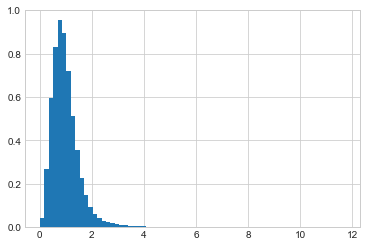

In [109]:
s = np.genfromtxt("hermitian_spacings.txt")
s_diagonal = np.genfromtxt("diagonal_spacings.txt")

#create bins; max s = 11

_ = plt.hist(s, density = True, bins=np.linspace(0, max(s),70))

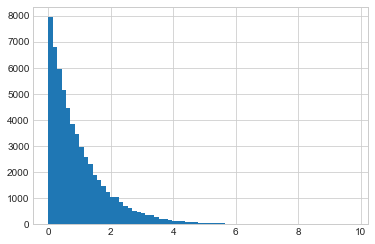

In [110]:
_ = plt.hist(s_diagonal, bins=np.linspace(0, max(s_diagonal),70))

In [111]:
#entropy minimization on data
def log_wigner_function(x, b, alfa, beta):
    return np.log(x)*alfa - b*x**beta

def log_wigner_model(x, b, alfa, beta):
    """Model for the probability distribution."""
    return log_wigner_function(x, b, alfa, beta) - log_normalization(b, alfa, beta)

# small optimization: cache the last-recently-used results
# for the integral computation, parameter a = 1/normalization
@lru_cache() 
def log_normalization(b, alfa, beta):
    log_f = partial(log_wigner_function, b=b, alfa=alfa, beta=beta)
    return np.log(quad(lambda x : np.exp(log_f(x)), 0, np.inf)[0]) # quad also returns the estimated error of integration

def entropy(data, log_model):
    return np.average(-log_model(data))

def score(params):
    """Given the parameters of the distribution, 
    return the entropy computed on the data."""
    b, alfa, beta = params
    model = partial(log_wigner_model, b = b, alfa = alfa, beta = beta)
    return entropy(nums, model)


#good form because it comes from a module, not necessary here 
#https://www.geeksforgeeks.org/what-does-the-if-__name__-__main__-do/
if __name__ == "__main__":

    #nums is data, x0 initial guess comes from theory 
    nums = s[ s < 2.5]
    
    th_params = [4 / np.pi, 2, 2]
    
    result = minimize(score, x0=th_params, 
                      method='CG', 
                     )
#     different solvers are found at https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    

    print(result.x)
    print(f'entropy with current optimization = {result.fun:.3f}')
    print(f'entropy for th params = {score(th_params):.3f}')
    print(f'(less entropy means a better fit)')
    norm = np.exp(log_normalization(*result.x))
    a = 1/norm
    print(a)

[2.49172374 2.35794554 1.38453572]
entropy with current optimization = 0.540
entropy for th params = 0.558
(less entropy means a better fit)
10.034871115514587


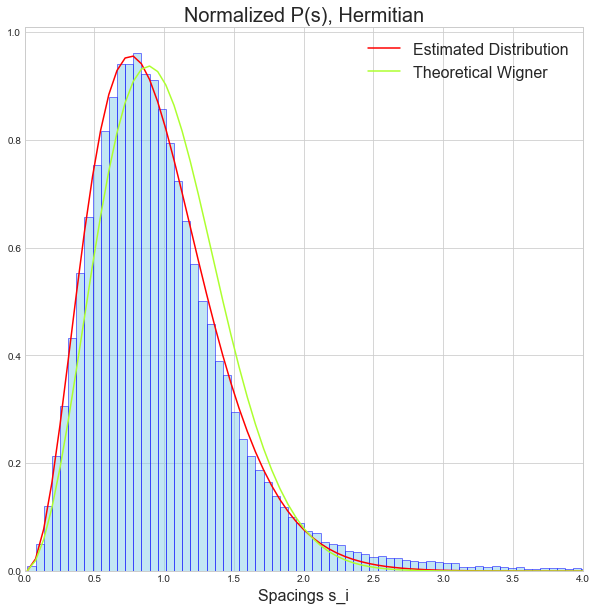

In [112]:
fig, ax = plt.subplots(figsize = (10,10))
vals, bins, _ = ax.hist(s, density = True, bins=200, color = "skyblue", edgecolor='blue', histtype='bar', alpha = 0.5)

#to call the resulting parameter use *
ax.plot(bins, np.exp(log_wigner_model(bins, *result.x)), label='Estimated Distribution', color = 'red')
ax.plot(bins, np.exp(log_wigner_model(bins, 4 / np.pi, 2, 2)), label='Theoretical Wigner', color = 'greenyellow')
ax.axis(xmin = 0, xmax = 4)
ax.legend()
ax.set_title('Normalized P(s), Hermitian')
ax.set_xlabel('Spacings s_i')

plt.savefig("hermitian.pdf")

In [114]:
norm = np.exp(log_normalization(4 / np.pi, 2,  2))
print('exp:', norm, 1/norm)
print('theory:', 1 / (32 / np.pi**2) , (32 / np.pi**2) )
# the theoretical parameters are internally consistent!


exp: 0.3084251375340424 3.2422778765548093
theory: 0.30842513753404244 3.242277876554809


[0.98906086 1.00773546]
entropy with current optimization = 1.000
entropy for th params = 1.000
(less entropy means a better fit)
0.992340801745011


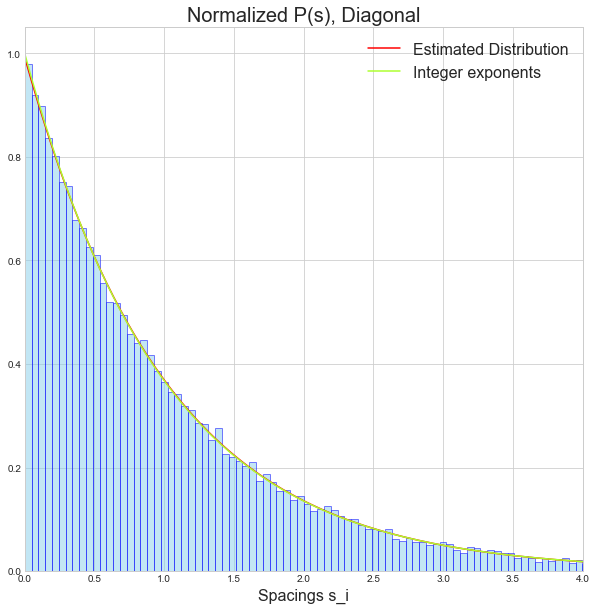

In [115]:
#entropy minimization on data
def log_wigner_function(x, b, beta):
    return - b*x**beta

def log_wigner_model(x, b, beta):
    """Model for the probability distribution."""
    return log_wigner_function(x, b, beta) - log_normalization(b, beta)

# small optimization: cache the last-recently-used results
# for the integral computation
@lru_cache() 
def log_normalization(b, beta):
    log_f = partial(log_wigner_function, b=b, beta=beta)
    return np.log(quad(lambda x : np.exp(log_f(x)), 0, np.inf)[0]) # quad also returns the estimated error of integration

def entropy(data, log_model):
    return np.average(-log_model(data))

def score(params):
    """Given the parameters of the distribution, 
    return the entropy computed on the data."""
    b, beta = params
    model = partial(log_wigner_model, b = b, beta = beta)
    return entropy(nums, model)

#ignore it, not used in code, it was for having alfa > 0 but there still were convergence problems
def ineq_constraint(x):
    """constrain all elements of x to be >= 0"""
    return x
constraints = [{'type': 'ineq', 'fun': ineq_constraint}]

if __name__ == "__main__":

    #nums is data, x0 initial guess comes from theory 
    nums = s_diagonal
    th_params = [1, 1]
    
    result = minimize(score, x0=th_params,
                      constraints=constraints
                     )

fig, ax = plt.subplots(figsize = (10,10))
vals, bins, _ = ax.hist(s_diagonal, density = True, bins=200, color = "skyblue", edgecolor='blue', histtype='bar', alpha = 0.5)

#to call the resulting parameter use *
ax.plot(bins, np.exp(log_wigner_model(bins, *result.x)), label='Estimated Distribution', color = 'red', )
ax.plot(bins, np.exp(log_wigner_model(bins, 1,1)), label='Integer exponents ', color = 'greenyellow')
ax.axis(xmin = 0, xmax = 4)
ax.legend()
ax.set_title('Normalized P(s), Diagonal')
ax.set_xlabel('Spacings s_i')

print(result.x)
print(f'entropy with current optimization = {result.fun:.3f}')
print(f'entropy for th params = {score(th_params):.3f}')
print(f'(less entropy means a better fit)')
norm = np.exp(log_normalization(*result.x))
a = 1/norm
print(a)

plt.savefig("diagonal.pdf")

In [116]:
norm = np.exp(log_normalization(1,1))
1/norm

0.9999999999999998